## Sentiment Analysis

As we transition into the sentiment analysis phase of our project, we are set to embark on a nuanced exploration of the sentiments associated with the two dominant topics identified by our Latent Dirichlet Allocation (LDA) model. Recognizing the complexity and sensitivity of the subject matter, especially in the context of the Israeli-Palestinian conflict, our approach is tailored to capture a wide spectrum of sentiments. We will conduct a **multilabel sentiment analysis**.

For the topic **"Economic and Financial Implications in Israel-Hamas Narratives"** we will utilize a specialized set of sentiment labels to understand the economic perspectives conveyed in the text. Our classification will include the following labels:

* "Contributes positively to the economy"
* "Contributes negatively to the economy"
* "No significant impact on the economy"

This targeted approach aims to capture the diverse range of economic sentiments and their perceived impacts, offering insights into the financial dimensions of the discourse.

Regarding the topic **"Israeli-Palestinian Conflict: The Gaza Perspective"** we will employ a different set of sentiment labels that are more aligned with the geopolitical nature of this topic:

* "Supportive of Israel's policies"
* "Supportive of Palestine's policies"
* "Critical of Israel's policies"
* "Critical of Palestine's policies"
* "Neutral or unbiased stance"

This categorization is intended to encompass the broad spectrum of political and social sentiments present in discussions surrounding the Israeli-Palestinian conflict.

To conduct this nuanced sentiment analysis, we will employ the zero-shot classification technique, utilizing the **"facebook/bart-large-mnli"** model from Hugging Face. This model is chosen for its ability to effectively classify complex textual content without needing specific examples for each sentiment category. Our goal with this methodology is to achieve a comprehensive and balanced analysis of sentiments across our dataset, thus illuminating the diverse viewpoints and stances within the discourse on these critical topics.


Beyond employing the zero-shot classification technique with the "facebook/bart-large-mnli" model from Hugging Face, we will also utilize the Afinn sentiment analysis tool. The Afinn analyzer assigns a numerical score to text, reflecting its overall sentiment polarity: positive, negative, or neutral. Scores above zero indicate positive sentiment, scores below zero indicate negative sentiment, and a score of zero denotes a neutral stance. This scoring system allows us to quantify sentiment in a more nuanced manner.

Afinn is a simple yet effective sentiment analysis tool that assigns scores to words based on their inherent sentiment, with its lexicon tailored specifically for short texts like tweets and headlines. The tool provides a straightforward way to get a quick sense of the overall sentiment of a piece of text, making it particularly useful for initial exploratory analysis. It's especially effective for capturing the sentiment of texts where the expression of emotions is more direct and less nuanced.

In our analysis, the Afinn tool will complement our zero-shot classification approach by providing an additional layer of sentiment quantification. We will analyze the sentiments in our dataset using both methodologies and compare the results in a grouped bar plot. This will enable us to present a comprehensive view, combining qualitative categorization with quantitative sentiment scoring, thereby enriching our understanding of the sentiments embedded in the discourse around these critical topics.

### Importing Necessary Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from transformers import pipeline
from afinn import Afinn
import seaborn as sns

### Initialization of functions

In [37]:
def classify_sentiment(text: str,
                       classes: list) -> str:
    """
    Classifies the sentiment of a given text using a pre-defined classifier and a specified set of candidate labels (classes).

    This function applies a sentiment classification model to the provided text. It uses a predefined classifier,
    configured with the provided candidate labels (classes), to determine the most relevant sentiment label for the text.
    In case of any exceptions during the classification process, the function returns a string indicating an error.

    Parameters:
    text (str): The text to be analyzed for sentiment.
    classes (list): A list of strings representing the candidate labels for sentiment classification.

    Returns:
    str: The most relevant sentiment label for the text, or 'error' in case of an exception during classification.
    """
    try:
        result = classifier(text, candidate_labels=classes)
        return result["labels"][0]
    except Exception as e:
        return "error"



def plot_sentiment_distribution(df: pd.DataFrame):
    """
    Plots the distribution of sentiment categories within a DataFrame.

    This function checks for a 'sentiment' column in the provided DataFrame. If present,
    it calculates the percentage of each sentiment category and plots a horizontal bar chart
    showing the distribution of these sentiments. The function also includes percentage annotations
    on each bar for better readability.

    Parameters:
    df (pd.DataFrame): A DataFrame containing sentiment data in a column named 'sentiment'.

    The function creates a bar plot where the y-axis represents different sentiment categories,
    and the x-axis shows the percentage of each sentiment category within the DataFrame.

    Note: This function requires the seaborn and matplotlib libraries for plotting.
    """

    if 'sentiment' not in df.columns:
        print("DataFrame does not contain a 'sentiment' column.")
        return

    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100

    plt.figure(figsize=(10, 6))

    ax = sns.barplot(x=sentiment_counts.values, y=sentiment_counts.index, palette="viridis")

    plt.xlabel('Percentage (%)')
    plt.ylabel('Sentiment')
    plt.title('Sentiment Distribution (Percentage)')

    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}%',
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left', va='center')

    plt.show()


def plot_grouped_sentiment(df: pd.DataFrame):
    """
    Generates a horizontal grouped bar plot with percentage annotations for sentiment analysis of a DataFrame.

    This function creates a horizontal grouped bar plot where each group represents a specific sentiment,
    and within each group, there are bars for different sentiment categories showing their count. Each bar
    will have a percentage label beside it.

    Parameters:
    df (pd.DataFrame): A DataFrame containing sentiment analysis data, with columns for
                       'sentiment', 'sentiment_score', and 'sentiment_category'.
    """
    if 'sentiment' not in df.columns or 'sentiment_category' not in df.columns:
        print("Required columns 'sentiment' or 'sentiment_category' are missing in the DataFrame")
        return

    # Create a horizontal grouped bar plot
    plt.figure(figsize=(12, 8))
    g = sns.catplot(y='sentiment', hue='sentiment_category', kind='count', data=df, palette='plasma', height=6, aspect=2, orient='h')

    # Adjust the existing legend
    for t in g._legend.texts:
        t.set_text(t.get_text().replace('_', ' '))
    g._legend.set_title('Afinn Sentiment')

    # Add percentage labels
    for p in g.ax.patches:
        txt = str(round((p.get_width() / df.shape[0]) * 100, 2)) + '%'
        g.ax.text(p.get_width(), p.get_y() + p.get_height() / 2, txt, color='black', ha="left", va="center")

    plt.title('Comparison Sentiment Analysis: Afinn vs Zero-Shot')
    plt.xlabel('Number of News')
    plt.ylabel('Zero Shot - Sentiment Categories')
    plt.show()


def apply_afinn_sentiment_analysis(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Applies Afinn sentiment analysis to a specified column in a DataFrame.

    This function adds two new columns to the DataFrame:
    - 'sentiment_score': Numeric sentiment score.
    - 'sentiment_category': Categorical sentiment label ('positive', 'negative', 'neutral').

    Parameters:
    df (pd.DataFrame): The DataFrame containing the text data.
    text_column (str): The name of the column in the DataFrame that contains the text to be analyzed.

    Returns:
    pd.DataFrame: The original DataFrame with two new columns for sentiment scores and categories.
    """
    # Initialize Afinn sentiment analyzer
    af = Afinn()

    # Compute sentiment scores for the specified text column
    df['sentiment_score'] = df[text_column].apply(af.score)

    # Assign sentiment categories based on the scores
    df['sentiment_category'] = df['sentiment_score'].apply(
        lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
    )

    df['sentiment_score'] = df['sentiment_score'].astype(float)

    return df

### Importing Dataset

In [4]:
df = pd.read_pickle('./Datasets/topics_lda.pkl')
df.head(5)

,title,url,date,source,text,preprocessed_text,Dominant_Topic,Topic_Title
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...,2,Israeli-Palestinian Conflict: The Gaza Perspec...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              2644 non-null   object
 1   url                2644 non-null   object
 2   date               2644 non-null   object
 3   source             2644 non-null   object
 4   text               2644 non-null   object
 5   preprocessed_text  2644 non-null   object
 6   Dominant_Topic     2644 non-null   int64 
 7   Topic_Title        2644 non-null   object
dtypes: int64(1), object(7)
memory usage: 165.4+ KB


### Importing Pre-Trained Model

In [ ]:
model_name = "facebook/bart-large-mnli"
classifier = pipeline("zero-shot-classification", model=model_name)

### Perfom Sentiment Analysis for topic "Israeli-Palestinian Conflict: The Gaza Perspective" using Zero-Shot Classification

In [5]:
topic_1_df = df[df['Topic_Title'] == 'Israeli-Palestinian Conflict: The Gaza Perspective']

# Define sentiment classes
classes = [
    "Supportive of Israel's policies",
    "Supportive of Palestine's policies",
    "Critical of Israel's policies",
    "Critical of Palestine's policies",
    "Neutral or unbiased stance"
]

# Process the DataFrame sequentially
results = []
for i in range(topic_1_df.shape[0]):
    text = topic_1_df['preprocessed_text'].iloc[i]
    sentiment = classify_sentiment(text, classes)
    results.append(sentiment)

    print(f"Processed {i} records out of {topic_1_df.shape[0]}")
    print(f"Sentiment {sentiment}")

topic_1_df['sentiment'] = results

print("Processing complete.")

topic_1_df.to_pickle('./Datasets/label_data_topic_1_df.pkl')

Processed 0 records out of 2405
Sentiment error
Processed 1 records out of 2405
Sentiment error
Processed 2 records out of 2405
Sentiment error
Processed 3 records out of 2405
Sentiment error
Processed 4 records out of 2405
Sentiment error
Processed 5 records out of 2405
Sentiment error
Processed 6 records out of 2405
Sentiment error
Processed 7 records out of 2405
Sentiment error
Processed 8 records out of 2405
Sentiment error
Processed 9 records out of 2405
Sentiment error
Processed 10 records out of 2405
Sentiment error
Processed 11 records out of 2405
Sentiment error
Processed 12 records out of 2405
Sentiment error
Processed 13 records out of 2405
Sentiment error
Processed 14 records out of 2405
Sentiment error
Processed 15 records out of 2405
Sentiment error
Processed 16 records out of 2405
Sentiment error
Processed 17 records out of 2405
Sentiment error
Processed 18 records out of 2405
Sentiment error
Processed 19 records out of 2405
Sentiment error
Processed 20 records out of 24

<ipython-input-5-f96c4b5e0628>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_1_df['sentiment'] = results


In [11]:
topic_1_sentiment_labelled = pd.read_pickle('./Datasets/label_data_topic_1_df.pkl')
topic_1_sentiment_labelled = topic_1_sentiment_labelled[topic_1_sentiment_labelled['sentiment'] != "error"]
topic_1_sentiment_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2374 entries, 0 to 2643
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              2374 non-null   object
 1   url                2374 non-null   object
 2   date               2374 non-null   object
 3   source             2374 non-null   object
 4   text               2374 non-null   object
 5   preprocessed_text  2374 non-null   object
 6   Dominant_Topic     2374 non-null   int64 
 7   Topic_Title        2374 non-null   object
 8   sentiment          2374 non-null   object
dtypes: int64(1), object(8)
memory usage: 185.5+ KB


C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


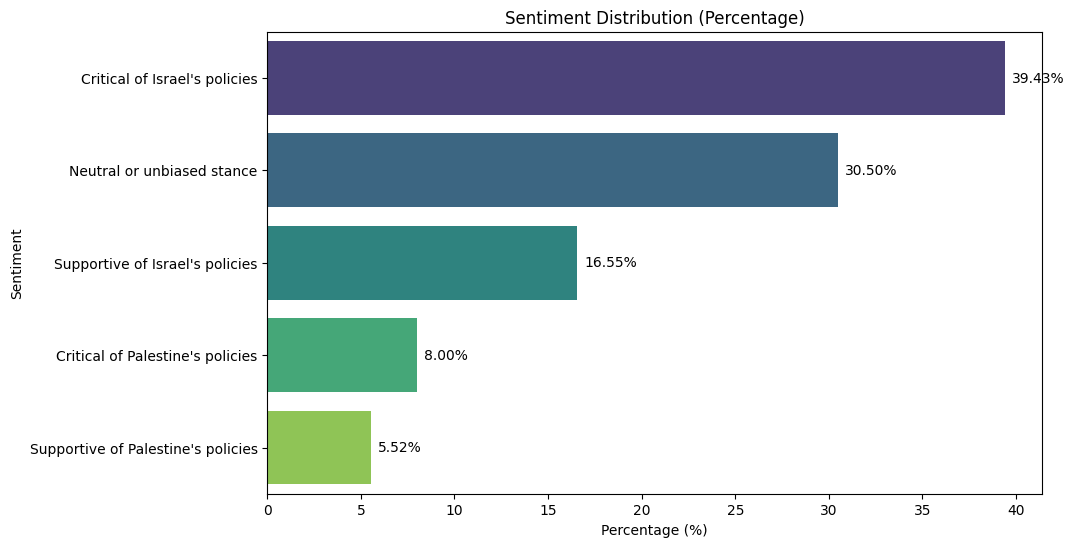

In [ ]:
plot_sentiment_distribution(topic_1_sentiment_labelled)

### Perfom Sentiment Analysis for topic "Economic and Financial Implications in Israel-Hamas Narratives" using Zero-Shot Classification

In [ ]:
topic_2_df = df[df['Topic_Title'] == 'Economic and Financial Implications in Israel-Hamas Narratives']

# Define sentiment classes
classes = [
    "Contributes positively to the economy",
    "Contributes negatively to the economy",
    "No significant impact on the economy"
]

# Process the DataFrame sequentially
results_2 = []
for i in range(topic_2_df.shape[0]):
    text = topic_2_df['preprocessed_text'].iloc[i]
    sentiment = classify_sentiment(text)
    results_2.append(sentiment)

    print(f"Processed {i} records out of {topic_2_df.shape[0]}")
    print(f"Sentiment {sentiment}")

topic_2_df['sentiment'] = results_2

print("Processing complete.")


topic_2_df.to_pickle('./Datasets/label_data_topic_2.pkl')

Processed 0 records out of 239
Sentiment Contributes positively to the economy
Processed 1 records out of 239
Sentiment Contributes positively to the economy
Processed 2 records out of 239
Sentiment Contributes positively to the economy
Processed 3 records out of 239
Sentiment Contributes positively to the economy
Processed 4 records out of 239
Sentiment Contributes positively to the economy
Processed 5 records out of 239
Sentiment Contributes negatively to the economy
Processed 6 records out of 239
Sentiment Contributes positively to the economy
Processed 7 records out of 239
Sentiment Contributes positively to the economy
Processed 8 records out of 239
Sentiment Contributes negatively to the economy
Processed 9 records out of 239
Sentiment Contributes positively to the economy
Processed 10 records out of 239
Sentiment Contributes positively to the economy
Processed 11 records out of 239
Sentiment Contributes negatively to the economy
Processed 12 records out of 239
Sentiment Contribu

Processed 103 records out of 239
Sentiment Contributes negatively to the economy
Processed 104 records out of 239
Sentiment Contributes negatively to the economy
Processed 105 records out of 239
Sentiment Contributes positively to the economy
Processed 106 records out of 239
Sentiment Contributes negatively to the economy
Processed 107 records out of 239
Sentiment Contributes positively to the economy
Processed 108 records out of 239
Sentiment Contributes negatively to the economy
Processed 109 records out of 239
Sentiment Contributes negatively to the economy
Processed 110 records out of 239
Sentiment Contributes positively to the economy
Processed 111 records out of 239
Sentiment Contributes negatively to the economy
Processed 112 records out of 239
Sentiment Contributes positively to the economy
Processed 113 records out of 239
Sentiment Contributes negatively to the economy
Processed 114 records out of 239
Sentiment Contributes positively to the economy
Processed 115 records out of

Processed 205 records out of 239
Sentiment Contributes positively to the economy
Processed 206 records out of 239
Sentiment Contributes negatively to the economy
Processed 207 records out of 239
Sentiment Contributes positively to the economy
Processed 208 records out of 239
Sentiment Contributes negatively to the economy
Processed 209 records out of 239
Sentiment Contributes positively to the economy
Processed 210 records out of 239
Sentiment Contributes negatively to the economy
Processed 211 records out of 239
Sentiment Contributes positively to the economy
Processed 212 records out of 239
Sentiment Contributes negatively to the economy
Processed 213 records out of 239
Sentiment Contributes negatively to the economy
Processed 214 records out of 239
Sentiment Contributes positively to the economy
Processed 215 records out of 239
Sentiment Contributes negatively to the economy
Processed 216 records out of 239
Sentiment Contributes negatively to the economy
Processed 217 records out of

C:\Users\ΑΝΤΩΝΙΟΣ ΜΑΥΡΙΔΗΣ\AppData\Local\Temp\ipykernel_18492\3824293307.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_2_df['sentiment'] = results_2


In [32]:
topic_2_sentiment = pd.read_pickle('./Datasets/label_data_topic_2.pkl')
topic_2_sentiment = topic_2_sentiment[topic_2_sentiment['sentiment'] != "error"]
topic_2_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 7 to 2601
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              239 non-null    object
 1   url                239 non-null    object
 2   date               239 non-null    object
 3   source             239 non-null    object
 4   text               239 non-null    object
 5   preprocessed_text  239 non-null    object
 6   Dominant_Topic     239 non-null    int64 
 7   Topic_Title        239 non-null    object
 8   sentiment          239 non-null    object
dtypes: int64(1), object(8)
memory usage: 18.7+ KB


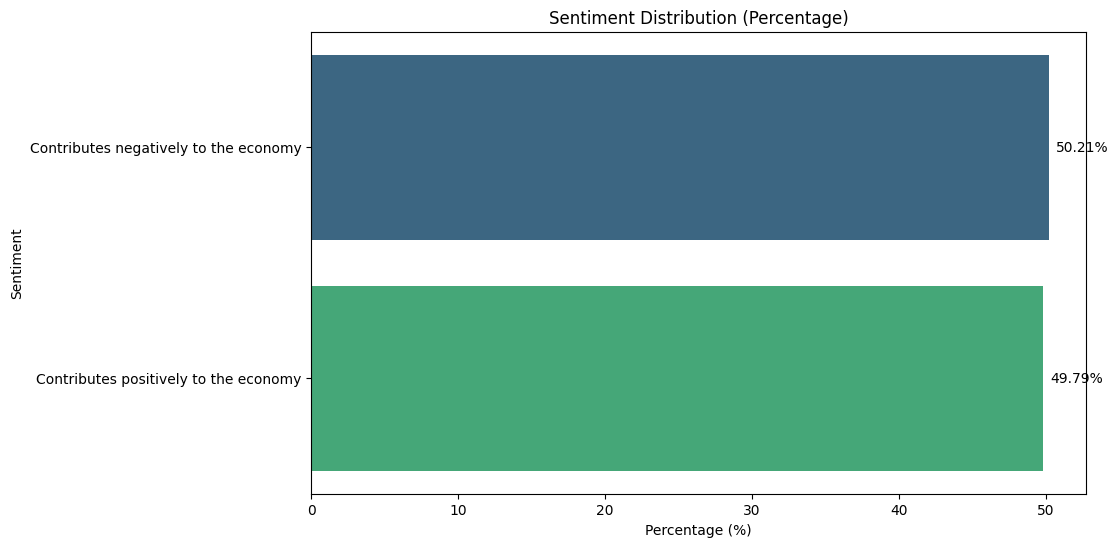

In [33]:
plot_sentiment_distribution(topic_2_sentiment)

### Sentiment Analysis with Afinn for topic **"Israeli-Palestinian Conflict: The Gaza Perspective"**

In [38]:
topic_1_sentiment_labelled = apply_afinn_sentiment_analysis(topic_1_sentiment_labelled, 'preprocessed_text')
topic_1_sentiment_labelled.head()

,title,url,date,source,text,preprocessed_text,Dominant_Topic,Topic_Title,sentiment,sentiment_score,sentiment_category
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...,2,Israeli-Palestinian Conflict: The Gaza Perspec...,Neutral or unbiased stance,-30.0,negative
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...,2,Israeli-Palestinian Conflict: The Gaza Perspec...,Critical of Palestine's policies,-81.0,negative
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...,2,Israeli-Palestinian Conflict: The Gaza Perspec...,Supportive of Israel's policies,-15.0,negative
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...,2,Israeli-Palestinian Conflict: The Gaza Perspec...,Neutral or unbiased stance,-3.0,negative
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...,2,Israeli-Palestinian Conflict: The Gaza Perspec...,Supportive of Israel's policies,41.0,positive


<Figure size 1200x800 with 0 Axes>

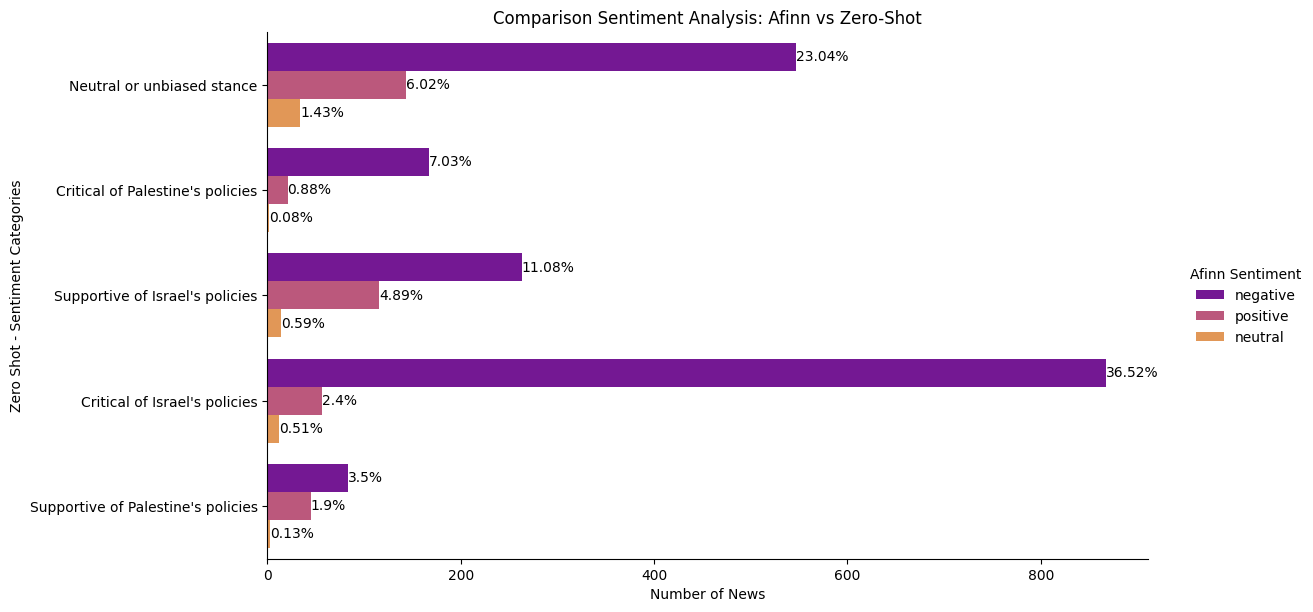

In [39]:
plot_grouped_sentiment(topic_1_sentiment_labelled)

### Sentiment Analysis with Afinn for topic **"Economic and Financial Implications in Israel-Hamas Narratives"**

In [42]:
topic_2_sentiment = apply_afinn_sentiment_analysis(topic_2_sentiment, 'preprocessed_text')
topic_2_sentiment.head()

,title,url,date,source,text,preprocessed_text,Dominant_Topic,Topic_Title,sentiment,sentiment_score,sentiment_category
7,Oil climbs over 2% as OPEC seen deepening cuts,https://www.reuters.com/business/energy/oil-ex...,"November 20, 2023",Reuters,"HOUSTON, Nov 20 (Reuters) - Oil prices climbed...",oil price climbed supply cut opec production e...,3,Economic and Financial Implications in Israel-...,Contributes positively to the economy,-21.0,negative
11,Investors pump over $600 mln into defense fund...,https://www.reuters.com/business/aerospace-def...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Investors piled into exchan...,investor piled exchangetraded fund tracking de...,3,Economic and Financial Implications in Israel-...,Contributes positively to the economy,19.0,positive
23,"Major Gulf markets ease, Saudi to snap 4-day w...",https://www.reuters.com/markets/major-gulf-mar...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Major stock markets in the ...,major stock market gulf fell early trade marke...,3,Economic and Financial Implications in Israel-...,Contributes positively to the economy,1.0,positive
28,Morning Bid: Japanese stocks party like it's 1990,https://www.reuters.com/markets/europe/global-...,"November 20, 2023",Reuters,A look at the day ahead in European and global...,look day ahead european global market mixed st...,3,Economic and Financial Implications in Israel-...,Contributes positively to the economy,14.0,positive
39,Most Gulf markets gain on rising oil prices,https://www.reuters.com/markets/most-gulf-mark...,"November 19, 2023",Reuters,Nov 19 (Reuters) - Most stock markets in the G...,stock market gulf ended higher response friday...,3,Economic and Financial Implications in Israel-...,Contributes positively to the economy,10.0,positive


<Figure size 1200x800 with 0 Axes>

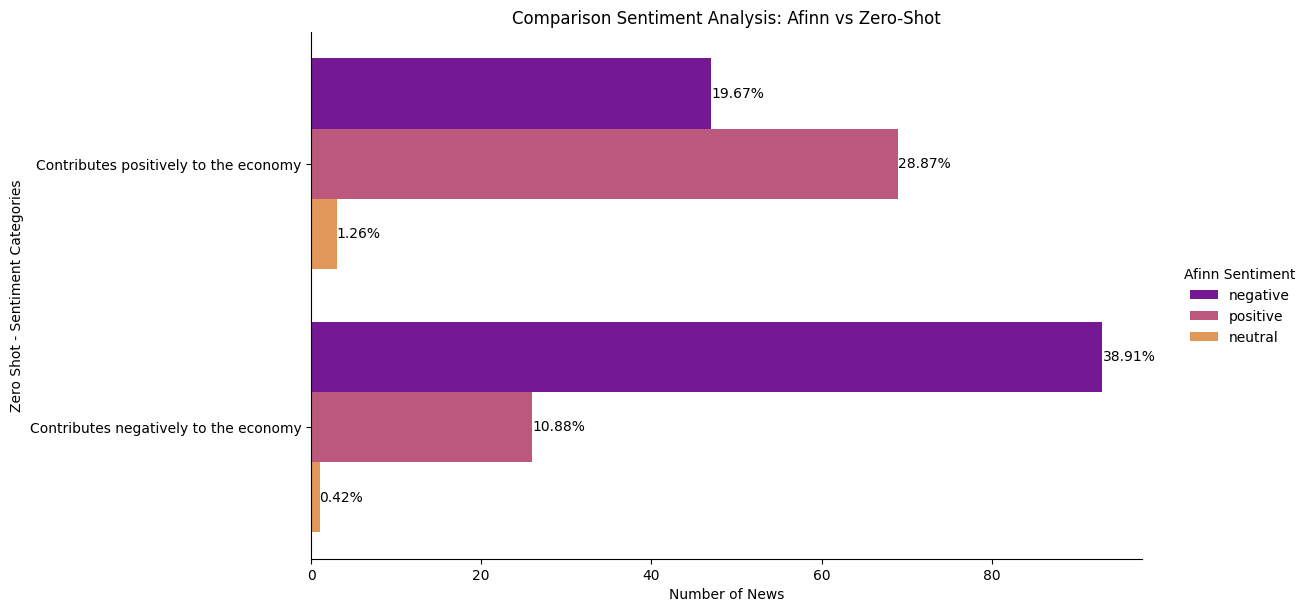

In [43]:
plot_grouped_sentiment(topic_2_sentiment)